<a href="https://colab.research.google.com/github/rhqrhq/Adversarial_Examples_Papers/blob/main/pTRpred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas==2.2.0


In [ ]:
pip install pmdarima

In [ ]:
# roll_windows
from typing import Sequence, Literal
import numpy as np
import pandas as pd
import pmdarima as pm

def roll_windows(
    time: Sequence,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
) -> pd.DataFrame:
    """
    Build rolling / expanding window indices over a time vector.
    """
    if window < 1:
        raise ValueError("`window` must be >= 1")
    if step < 1:
        raise ValueError("`step` must be >= 1")

    align = align.lower()
    if align not in {"end", "center", "start"}:
        raise ValueError("`align` must be one of {'end','center','start'}")

    type = type.lower()
    if type not in {"rolling", "expanding"}:
        raise ValueError("`type` must be one of {'rolling','expanding'}")

    ts = pd.Series(time)
    n = len(ts)

    if type == "rolling":
        if n < window:
            starts = np.array([1], dtype=int)
            ends   = np.array([n], dtype=int)
        else:
            starts = np.arange(1, n - window + 2, step, dtype=int)
            ends   = starts + window - 1
    else:
        if n < window:
            ends = np.array([n], dtype=int)
        else:
            ends = np.arange(window, n + 1, step, dtype=int)
            if ends.size == 0:
                ends = np.array([n], dtype=int)
        starts = np.full_like(ends, 1)

    if align == "end":
        t_rep_idx_1b = ends
    elif align == "start":
        t_rep_idx_1b = starts
    else:
        t_rep_idx_1b = np.floor((starts + ends) / 2).astype(int)

    t_rep = ts.iloc[t_rep_idx_1b - 1].to_numpy()
    idx_list = [list(range(int(s), int(e) + 1)) for s, e in zip(starts, ends)]

    out = pd.DataFrame({
        "window_id": np.arange(1, len(starts) + 1, dtype=int),
        "start": starts,
        "end": ends,
        "t_rep": t_rep,
        "idx": idx_list,
    })
    return out

In [ ]:
import pmdarima as pm

In [ ]:
# extract_X
import numpy as np
import pandas as pd
from typing import Sequence, Union
import pmdarima as pm

def extract_X(data: pd.DataFrame, x_cols: Union[Sequence[str], str]) -> pd.DataFrame:
    """
    Extract a numeric matrix (as a pandas DataFrame) from a data frame.

    Parameters
    ----------
    data : pd.DataFrame
        Must contain the columns of interest.
    x_cols : list of str or str
        - A list of exact column names, e.g. ["temp1","temp2"]
        - A single regex string containing '|' to match multiple names, e.g. "temp|volt"

    Returns
    -------
    pd.DataFrame
        Numeric DataFrame with preserved column names.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("`data` must be a pandas DataFrame.")

    if isinstance(x_cols, str):
        if "|" in x_cols:
            keep = data.filter(regex=x_cols).columns.tolist()
        else:
            keep = [x_cols]
    elif isinstance(x_cols, (list, tuple)):
        keep = list(x_cols)
    else:
        raise ValueError("`x_cols` must be a list of names or a single regex string.")

    if len(keep) == 0:
        raise ValueError("No columns selected by `x_cols`.")

    X = data.loc[:, keep].copy()
    for c in keep:
        X[c] = pd.to_numeric(X[c], errors="coerce")

    return X

In [ ]:
# na_handle
import numpy as np
import pandas as pd
from typing import Literal, Union

def na_handle(
    M: Union[np.ndarray, pd.DataFrame],
    method: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows"
) -> np.ndarray:
    """
    Simple NA handling for numeric matrices.

    Parameters
    ----------
    M : array-like (numpy array or pandas DataFrame)
        Numeric-like object.
    method : {"omit_rows","impute_mean","pairwise_complete"}
        - "omit_rows": drop any rows containing NaN
        - "impute_mean": impute NaNs with column means (if >=2 non-NA values)
        - "pairwise_complete": leave NAs as-is

    Returns
    -------
    numpy.ndarray
        Numeric matrix with NAs handled.
    """
    if isinstance(M, pd.DataFrame):
        A = M.to_numpy(dtype=float)
    else:
        A = np.asarray(M, dtype=float)

    if method == "omit_rows":
        mask = ~np.isnan(A).any(axis=1)
        return A[mask, :]

    if method == "impute_mean":
        A_copy = A.copy()
        for j in range(A_copy.shape[1]):
            col = A_copy[:, j]
            nan_mask = np.isnan(col)
            if not nan_mask.any():
                continue
            n_non_na = np.sum(~nan_mask)
            if n_non_na <= 1:
                # 0 or 1 observed values -> leave NaNs as NaN
                continue
            m = np.nanmean(col)
            A_copy[nan_mask, j] = m
        return A_copy

    if method == "pairwise_complete":
        return A

    raise ValueError("`method` must be one of {'omit_rows','impute_mean','pairwise_complete'}")

In [ ]:
# roll_svd
from typing import List, Optional, Sequence, Literal, Dict, Any
import numpy as np
import pandas as pd

# Assumes roll_windows, extract_X, and na_handle are already defined.

def _cov_window(
    Xc: pd.DataFrame,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"],
    cov_on_pairwise: bool
) -> np.ndarray:
    """
    Compute covariance for a single window, honoring pairwise-complete option.
    Returns a (p x p) numpy array.
    """
    if na_action == "pairwise_complete" and cov_on_pairwise:
        S = Xc.cov(min_periods=2)  # pairwise complete by default
        return S.to_numpy()
    else:
        Xc2 = Xc.dropna(axis=0, how="any")
        if Xc2.shape[0] < 2:
            return np.full((Xc.shape[1], Xc.shape[1]), np.nan, dtype=float)
        return np.cov(Xc2.to_numpy(), rowvar=False, ddof=1)

def roll_svd(
    data: pd.DataFrame,
    time: str,
    x_cols: Sequence[str] | str,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
    center: bool = True,
    scale_: bool = False,
    k: Optional[int] = None,
    fast: bool = True,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows",
    cov_on_pairwise: bool = True,
    values_only: bool = True,
    seed: Optional[int] = None,
) -> Dict[str, Any]:
    """
    Rolling SVD (eigendecomposition) of per-window covariance.

    Returns a dict with:
      - windows   : DataFrame from roll_windows (one row per window)
      - D         : list of 1D numpy arrays (eigenvalues per window)
      - V         : list of (p x k) numpy arrays (eigenvectors) or None if values_only
      - U_scores  : list of (n_w x k) numpy arrays (standardized scores) or None if values_only
      - k         : requested k (or None if not set)
      - colnames  : list of feature names
      - preproc   : {'center': bool, 'scale.': bool}
      - values_only : bool
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")
    if seed is not None:
        np.random.seed(seed)

    windows = roll_windows(data[time].to_numpy(), window, step, align, type)
    X_all = extract_X(data, x_cols)
    colnames = list(X_all.columns)
    p = X_all.shape[1]

    nW = windows.shape[0]
    D_list: List[Optional[np.ndarray]] = [None] * nW
    V_list: Optional[List[Optional[np.ndarray]]] = None if values_only else [None] * nW
    U_list: Optional[List[Optional[np.ndarray]]] = None if values_only else [None] * nW

    _have_scipy = False
    if fast:
        try:
            from scipy.sparse.linalg import eigsh  # type: ignore
            _have_scipy = True
        except Exception:
            _have_scipy = False

    for w in range(nW):
        idx_1b = windows.iloc[w]["idx"]          # list of 1-based indices
        idx_0b = [i - 1 for i in idx_1b]         # convert to 0-based
        Xw = X_all.iloc[idx_0b, :].copy()

        # NA handling (per window)
        if na_action == "omit_rows":
            Xw = Xw.dropna(axis=0, how="any")
        elif na_action == "impute_mean":
            Xw = Xw.copy()
            for c in Xw.columns:
                arr = Xw[c].to_numpy()
                nan_mask = np.isnan(arr)
                if nan_mask.any():
                    n_non_na = (~nan_mask).sum()
                    if n_non_na > 1:
                        Xw.loc[nan_mask, c] = np.nanmean(arr)
        elif na_action == "pairwise_complete":
            pass
        else:
            raise ValueError("`na_action` must be one of {'omit_rows','impute_mean','pairwise_complete'}")

        n_w = Xw.shape[0]
        if n_w < 2:
            continue  # skip this window; entries remain None

        # Center/scale per window
        if center:
            mu = Xw.mean(axis=0, skipna=True)
        else:
            mu = pd.Series(np.zeros(p), index=Xw.columns)

        if scale_:
            sc = Xw.std(axis=0, ddof=1, skipna=True).replace(0, np.nan)
        else:
            sc = pd.Series(np.ones(p), index=Xw.columns)

        sc = sc.fillna(1.0)
        Xc = (Xw - mu) / sc

        # Effective k for this window
        kk = min(k if k is not None else min(n_w, p), n_w, p)

        # Covariance for this window
        S = _cov_window(Xc, na_action, cov_on_pairwise)
        if not np.isfinite(S).all():
            continue

        if values_only:
            vals = np.linalg.eigvalsh(S)[::-1]  # descending
            D_list[w] = vals[:kk].copy()
        else:
            if _have_scipy and kk < p:
                from scipy.sparse.linalg import eigsh  # type: ignore
                vals, vecs = eigsh(S, k=kk, which="LA")
                order = np.argsort(-vals)
                vals = vals[order]
                vecs = vecs[:, order]
            else:
                vals_full, vecs_full = np.linalg.eigh(S)  # ascending
                order = np.argsort(-vals_full)
                vals = vals_full[order][:kk]
                vecs = vecs_full[:, order][:, :kk]

            D_list[w] = vals.copy()
            V_list[w] = vecs.copy() if V_list is not None else None
            if U_list is not None:
                U_list[w] = Xc.to_numpy() @ vecs

    return {
        "windows": windows,
        "D": D_list,
        "V": V_list,
        "U_scores": U_list,
        "k": (None if k is None else int(k)),
        "colnames": colnames,
        "preproc": {"center": bool(center), "scale.": bool(scale_)},
        "values_only": bool(values_only),
    }

In [ ]:
# fit_arimax_vec
import numpy as np
from typing import Optional, Dict, Any
import warnings

def fit_arimax_vec(
    y,
    xreg: Optional[np.ndarray] = None,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    **kwargs: Any,
) -> Dict[str, Any]:
    """
    Fit a single ARIMAX model (auto-selected order) and return aligned residuals/fitted.

    Parameters
    ----------
    y : array-like
        Dependent (response) series.
    xreg : array-like, optional
        Exogenous regressors (rows must align with y).
    seasonal : bool, default True
        Passed to pmdarima.auto_arima.
    stepwise : bool, default True
        Passed to pmdarima.auto_arima.
    approximation : bool, default False
        Passed to pmdarima.auto_arima.
    **kwargs :
        Additional arguments forwarded to pmdarima.auto_arima().

    Returns
    -------
    dict with keys:
      - model      : fitted pmdarima model object
      - residuals  : np.ndarray (residuals for the rows used)
      - fitted     : np.ndarray (fitted values for the rows used)
      - mask       : np.ndarray of bools (length len(y)), True where rows were used
    """
    try:
        import pmdarima as pm
    except Exception as e:
        raise ImportError(
            "Package 'pmdarima' is required but not installed. "
            "Install it with: pip install pmdarima"
        ) from e

    y_arr = np.asarray(y, dtype=float).reshape(-1)
    n = y_arr.shape[0]

    if xreg is not None:
        X = np.asarray(xreg, dtype=float)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        if X.shape[0] != n:
            raise ValueError("`xreg` must have the same number of rows as `y`.")
        ok = np.isfinite(y_arr) & np.isfinite(X).all(axis=1)
        X_used = X[ok, :]
    else:
        ok = np.isfinite(y_arr)
        X_used = None

    if not np.any(ok):
        raise ValueError("No complete cases available for ARIMAX fit.")

    y_used = y_arr[ok]

    # Silence convergence/numerical warnings unless user wants them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = pm.auto_arima(
            y=y_used,
            X=X_used,
            seasonal=seasonal,
            stepwise=stepwise,
            approximation=approximation,
            error_action="warn",
            suppress_warnings=True,
            **kwargs,
        )

    # In-sample predictions and residuals on the used subset
    try:
        fitted_used = model.predict_in_sample(X=X_used)
    except TypeError:
        # older pmdarima signature may use 'exogenous'
        fitted_used = model.predict_in_sample(exogenous=X_used)

    # Some versions expose residuals via .resid(), others via attribute
    try:
        resid_used = model.resid()
    except Exception:
        resid_used = y_used - np.asarray(fitted_used, dtype=float)

    fitted_used = np.asarray(fitted_used, dtype=float).reshape(-1)
    resid_used = np.asarray(resid_used, dtype=float).reshape(-1)

    return {
        "model": model,
        "residuals": resid_used,
        "fitted": fitted_used,
        "mask": ok,
    }

In [ ]:
import numpy as np
import pandas as pd
from typing import Sequence, Dict, Any, Optional
import pmdarima as pm

# Assumes extract_X(...) and fit_arimax_vec(...) are defined.

def arimax_residuals_df(
    data: pd.DataFrame,
    time: str,
    y_cols: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    **kwargs: Any,
) -> Dict[str, Any]:
    """
    Batch ARIMAX residuals for multiple series with a common regressor set.

    Returns
    -------
    dict with keys:
      - residuals_df : DataFrame with columns [time] + one column per y series
      - models       : dict of fitted models keyed by series name
      - mask         : boolean mask (length nrow(data)) for rows used (complete cases)
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")

    Ymat = extract_X(data, y_cols)          # n x p_y
    Xreg = extract_X(data, xreg_cols)       # n x p_x
    tvec = data[time].to_numpy()

    # Global complete-case mask across all selected y and xreg columns
    ok = np.isfinite(Ymat.to_numpy()).all(axis=1) & np.isfinite(Xreg.to_numpy()).all(axis=1)
    if not np.any(ok):
        raise ValueError("No complete cases across y_cols and xreg_cols for ARIMAX.")

    Y_ok = Ymat.loc[ok, :].reset_index(drop=True)
    X_ok = Xreg.loc[ok, :].reset_index(drop=True)
    t_ok = tvec[ok]

    n_ok, p_y = Y_ok.shape
    Resids = np.full((n_ok, p_y), np.nan, dtype=float)
    models: Dict[str, Any] = {}

    for j, col in enumerate(Y_ok.columns):
        fitj = fit_arimax_vec(
            y=Y_ok[col].to_numpy(),
            xreg=X_ok.to_numpy(),
            seasonal=seasonal,
            stepwise=stepwise,
            approximation=approximation,
            **kwargs,
        )
        inner_ok = fitj["mask"]  # mask relative to Y_ok (length n_ok)
        Resids[inner_ok, j] = fitj["residuals"]
        models[col] = fitj["model"]

    residuals_df = pd.DataFrame({"time": t_ok})
    for j, col in enumerate(Y_ok.columns):
        residuals_df[col] = Resids[:, j]

    return {"residuals_df": residuals_df, "models": models, "mask": ok}

In [ ]:
# arimax_residuals_df
import numpy as np
import pandas as pd
from typing import Sequence, Dict, Any, Optional

# Assumes extract_X(...) and fit_arimax_vec(...) are defined.

def arimax_residuals_df(
    data: pd.DataFrame,
    time: str,
    y_cols: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    **kwargs: Any,
) -> Dict[str, Any]:
    """
    Batch ARIMAX residuals for multiple series with a common regressor set.

    Returns
    -------
    dict with keys:
      - residuals_df : DataFrame with columns [time] + one column per y series
      - models       : dict of fitted models keyed by series name
      - mask         : boolean mask (length nrow(data)) for rows used (complete cases)
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")

    Ymat = extract_X(data, y_cols)          # n x p_y
    Xreg = extract_X(data, xreg_cols)       # n x p_x
    tvec = data[time].to_numpy()

    # Global complete-case mask across all selected y and xreg columns
    ok = np.isfinite(Ymat.to_numpy()).all(axis=1) & np.isfinite(Xreg.to_numpy()).all(axis=1)
    if not np.any(ok):
        raise ValueError("No complete cases across y_cols and xreg_cols for ARIMAX.")

    Y_ok = Ymat.loc[ok, :].reset_index(drop=True)
    X_ok = Xreg.loc[ok, :].reset_index(drop=True)
    t_ok = tvec[ok]

    n_ok, p_y = Y_ok.shape
    Resids = np.full((n_ok, p_y), np.nan, dtype=float)
    models: Dict[str, Any] = {}

    for j, col in enumerate(Y_ok.columns):
        fitj = fit_arimax_vec(
            y=Y_ok[col].to_numpy(),
            xreg=X_ok.to_numpy(),
            seasonal=seasonal,
            stepwise=stepwise,
            approximation=approximation,
            **kwargs,
        )
        inner_ok = fitj["mask"]  # mask relative to Y_ok (length n_ok)
        Resids[inner_ok, j] = fitj["residuals"]
        models[col] = fitj["model"]

    residuals_df = pd.DataFrame({"time": t_ok})
    for j, col in enumerate(Y_ok.columns):
        residuals_df[col] = Resids[:, j]

    return {"residuals_df": residuals_df, "models": models, "mask": ok}

In [ ]:
# arimax_then_roll_svd
import pandas as pd
from typing import Sequence, Dict, Any, Optional, Literal

def arimax_then_roll_svd(
    data: pd.DataFrame,
    time: str,
    y_cols: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
    center: bool = True,
    scale_: bool = False,
    k: Optional[int] = None,
    fast: bool = True,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows",
    cov_on_pairwise: bool = True,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    values_only: bool = True,
    seed: Optional[int] = None,
    **kwargs: Any,
) -> Dict[str, Any]:
    """
    Pipeline: ARIMAX residuals → rolling SVD on residual covariance.

    Returns
    -------
    dict with keys:
      - residuals_df : DataFrame of aligned ARIMAX residuals with a 'time' column
      - rollsvd      : dict returned by roll_svd(...)
      - models       : dict of fitted ARIMAX models keyed by series name
      - mask         : boolean mask over original rows used in ARIMAX fits
    """
    fit = arimax_residuals_df(
        data=data,
        time=time,
        y_cols=y_cols,
        xreg_cols=xreg_cols,
        seasonal=seasonal,
        stepwise=stepwise,
        approximation=approximation,
        **kwargs,
    )

    residuals_df = fit["residuals_df"]
    # Feature columns are everything after 'time'
    res_cols = [c for c in residuals_df.columns if c != "time"]

    svd_fit = roll_svd(
        data=residuals_df,
        time="time",
        x_cols=res_cols,                 # pass explicit list of columns
        window=window,
        step=step,
        align=align,
        type=type,
        center=center,
        scale_=scale_,
        k=k,
        fast=fast,
        na_action=na_action,
        cov_on_pairwise=cov_on_pairwise,
        values_only=values_only,
        seed=seed,
    )

    return {
        "residuals_df": residuals_df,
        "rollsvd": svd_fit,
        "models": fit["models"],
        "mask": fit["mask"],
    }

In [ ]:
# as_tibble_rollsvd
import pandas as pd
from typing import Literal, Dict, Any, List, Optional

def as_tibble_rollsvd(
    x: Dict[str, Any],
    what: Literal["loadings", "singular_values"] = "singular_values",
) -> Optional[pd.DataFrame]:
    """
    Tidy a rollsvd object (dict from roll_svd) into a long DataFrame.

    Parameters
    ----------
    x : dict
        Output from roll_svd(...).
    what : {"loadings","singular_values"}, default "singular_values"
        - "loadings": requires roll_svd(..., values_only=False).
          Returns columns: window_id, variable, factor, loading.
        - "singular_values": always available.
          Returns columns: window_id, factor, d.

    Returns
    -------
    pd.DataFrame or None
        Long-format DataFrame, or None if no windows contained results.
    """
    if not isinstance(x, dict) or "D" not in x:
        raise ValueError("`x` must be a dict returned by roll_svd (with key 'D').")

    V_list: Optional[List[Optional[Any]]] = x.get("V", None)
    D_list: List[Optional[Any]] = x.get("D", [])
    colnames: List[str] = x.get("colnames", [])

    if V_list is not None:
        W = len(V_list)
    elif D_list is not None:
        W = len(D_list)
    else:
        W = 0

    if W == 0:
        return None

    out_frames: List[pd.DataFrame] = []

    if what == "loadings":
        if V_list is None:
            raise ValueError("Loadings not available: roll_svd was run with values_only=True.")
        for w in range(W):
            V = V_list[w]
            if V is None:
                continue
            p, k = V.shape
            dfw = pd.DataFrame({
                "window_id": (w + 1),
                "variable": colnames * k,
                "factor": sum(([i + 1] * p for i in range(k)), []),
                "loading": V.reshape(-1, order="F"),  # match as.vector(column-major)
            })
            out_frames.append(dfw)
    elif what == "singular_values":
        for w in range(W):
            D = D_list[w]
            if D is None:
                continue
            dfw = pd.DataFrame({
                "window_id": (w + 1),
                "factor": list(range(1, len(D) + 1)),
                "d": list(map(float, D)),
            })
            out_frames.append(dfw)
    else:
        raise ValueError("`what` must be 'loadings' or 'singular_values'.")

    if not out_frames:
        return None

    out = pd.concat(out_frames, axis=0, ignore_index=True)
    return out

In [ ]:
# signals
import numpy as np
import pandas as pd
from typing import Sequence, Literal, Optional, Any

# Assumes: roll_svd, extract_X, fit_arimax_vec, arimax_residuals_df are defined.

def build_signal_raw(data: pd.DataFrame, time: str, col: str) -> pd.DataFrame:
    """
    Raw single-column series → (time_ind, signal)
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")
    if col not in data.columns:
        raise ValueError("`col` must be a column in `data`.")
    return pd.DataFrame({
        "time_ind": data[time].to_numpy(),
        "signal": pd.to_numeric(data[col], errors="coerce").to_numpy(),
    })

def build_signal_svd(
    data: pd.DataFrame,
    time: str,
    x_cols: Sequence[str] | str,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
    center: bool = True,
    scale_: bool = True,
    fast: bool = True,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows",
    cov_on_pairwise: bool = True,
    seed: Optional[int] = None,
) -> pd.DataFrame:
    """
    Rolling SVD top eigenvalue (s1) → (t_rep, s1)
    """
    fit = roll_svd(
        data=data, time=time, x_cols=x_cols,
        window=window, step=step, align=align, type=type,
        center=center, scale_=scale_, k=1,
        fast=fast, na_action=na_action, cov_on_pairwise=cov_on_pairwise,
        values_only=True, seed=seed
    )
    # Extract s1 per window; windows without values -> NaN
    s1 = [ (np.nan if (d is None or len(d) < 1) else float(d[0])) for d in fit["D"] ]
    return pd.DataFrame({
        "time_ind": fit["windows"]["t_rep"].to_numpy(),
        "signal": np.asarray(s1, dtype=float)
    })

def build_signal_arimax_resid(
    data: pd.DataFrame,
    time: str,
    y_col: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    **kwargs: Any,
) -> pd.DataFrame:
    """
    ARIMAX residuals (single y + predictors) → (time_ind, residual)
    """
    if time not in data.columns:
        raise ValueError("`time` must be a column in `data`.")

    y_df = extract_X(data, y_col)
    if y_df.shape[1] != 1:
        raise ValueError("`y_col` must select exactly one column.")
    X = extract_X(data, xreg_cols)

    t = data[time].to_numpy()
    fit = fit_arimax_vec(
        y=y_df.iloc[:, 0].to_numpy(),
        xreg=X.to_numpy(),
        seasonal=seasonal,
        stepwise=stepwise,
        approximation=approximation,
        **kwargs
    )
    return pd.DataFrame({
        "time_ind": t[fit["mask"]],
        "signal": fit["residuals"]
    })

def build_signal_arimax_svd(
    data: pd.DataFrame,
    time: str,
    y_cols: Sequence[str] | str,
    xreg_cols: Sequence[str] | str,
    window: int,
    step: int = 1,
    align: Literal["end", "center", "start"] = "end",
    type: Literal["rolling", "expanding"] = "rolling",
    center: bool = True,
    scale_: bool = True,
    fast: bool = True,
    na_action: Literal["omit_rows","impute_mean","pairwise_complete"] = "omit_rows",
    cov_on_pairwise: bool = True,
    seasonal: bool = True,
    stepwise: bool = True,
    approximation: bool = False,
    seed: Optional[int] = None,
    **kwargs: Any,
) -> pd.DataFrame:
    """
    ARIMAX residuals for multiple series → rolling SVD s1 → (t_rep, s1)
    """
    # 1) residuals (aligned by common mask)
    arx = arimax_residuals_df(
        data=data, time=time, y_cols=y_cols, xreg_cols=xreg_cols,
        seasonal=seasonal, stepwise=stepwise, approximation=approximation, **kwargs
    )

    # 2) SVD on residuals (s1 only)
    residuals_df = arx["residuals_df"]
    res_cols = [c for c in residuals_df.columns if c != "time"]

    fit = roll_svd(
        data=residuals_df, time="time", x_cols=res_cols,
        window=window, step=step, align=align, type=type,
        center=center, scale_=scale_, k=1,
        fast=fast, na_action=na_action, cov_on_pairwise=cov_on_pairwise,
        values_only=True, seed=seed
    )

    s1 = [ (np.nan if (d is None or len(d) < 1) else float(d[0])) for d in fit["D"] ]
    return pd.DataFrame({
        "time_ind": fit["windows"]["t_rep"].to_numpy(),
        "signal": np.asarray(s1, dtype=float)
    })

In [ ]:
# detect_asvotes
import numpy as np
from typing import Literal, Union, Sequence

def detect_asvotes(
    signal: Union[Sequence[float], np.ndarray],
    lowwl: int = 5,
    highwl: Union[str, int] = "auto",
    mad_k: float = 3.0,
    direction: Literal["positive", "both", "negative"] = "positive",
) -> np.ndarray:
    """
    Multi-scale robust slope voting detector (AS-votes).

    Parameters
    ----------
    signal : array-like
        Univariate time series.
    lowwl : int, default 5
        Minimum window length to scan.
    highwl : {"auto", int}, default "auto"
        If "auto", uses floor(n/3). If int, coerced and clipped to be >= lowwl.
    mad_k : float, default 3.0
        Threshold in robust median/MAD z-score units to flag outlying slopes.
    direction : {"positive","both","negative"}, default "positive"
        Which slope outliers contribute votes.

    Returns
    -------
    np.ndarray
        Vector of length n with normalized vote score per index.
    """
    y = np.asarray(signal, dtype=float).reshape(-1)
    n = y.size
    if n < 3:
        return np.zeros(n, dtype=float)

    if isinstance(highwl, str) and highwl.lower() == "auto":
        highwl_val = max(5, n // 3)
    else:
        highwl_val = int(highwl)

    lowwl_val = int(lowlw := lowwl)
    if highwl_val < lowwl_val:
        highwl_val = lowwl_val

    wls = np.arange(lowlw, highwl_val + 1, dtype=int)
    votes = np.zeros(n, dtype=float)
    n_wls = wls.size

    def robust_z(x: np.ndarray) -> np.ndarray:
        med = np.nanmedian(x)
        mad = np.nanmedian(np.abs(x - med))
        if not np.isfinite(mad) or mad == 0:
            mad = 1e-8
        return (x - med) / mad

    for w in wls:
        rem = n % w
        if rem == 0:
            start0 = 0
            end0_ex = n
        else:
            pad = rem // 2
            start0 = pad
            end0_ex = n - (rem - pad)

        L = end0_ex - start0
        if L < w:
            continue

        B = L // w  # number of full blocks
        # Centered time indices (no intercept)
        t = np.arange(1, w + 1, dtype=float)
        t_centered = t - (w + 1) / 2.0
        denom = np.dot(t_centered, t_centered)

        y_seg = y[start0:end0_ex]
        # reshape to (w x B) column-blocks, column-major like R's byrow=FALSE
        y_mat = y_seg.reshape(w, B, order="F")

        has_na = ~np.isfinite(y_mat).all(axis=0)
        num = t_centered @ y_mat  # (w,) @ (w,B) -> (B,)
        slopes = num / denom
        slopes[has_na] = np.nan

        z = robust_z(slopes)
        if not np.isfinite(z).any():
            continue

        vote_sign = np.zeros(B, dtype=int)
        if direction == "positive":
            vote_sign[z > mad_k] = 1
        elif direction == "negative":
            vote_sign[z < -mad_k] = 1  # presence of negative ramps counts as +1
        else:  # both
            vote_sign[z > mad_k] = 1
            vote_sign[z < -mad_k] = -1

        nz_blocks = np.nonzero(vote_sign != 0)[0]
        if nz_blocks.size > 0:
            for b in nz_blocks:
                block_start = start0 + b * w
                votes[block_start:block_start + w] += vote_sign[b]

    if n_wls > 0:
        votes = votes / n_wls
    return votes

In [ ]:
# detect_realtime
import numpy as np
import pandas as pd
from typing import Literal, Union, Sequence, Optional


def detect_realtime(
    time: Sequence,
    signal: Union[Sequence[float], np.ndarray],
    lowwl: int = 5,
    highwl: Union[str, int] = "auto",
    mad_k: float = 3.0,
    direction: Literal["positive", "both", "negative"] = "positive",
    burn_in: Optional[int] = None,
    smooth_k: int = 30,
    threshold: float = 1.3,
) -> pd.DataFrame:
    """
    Real-time multi-scale slope voting (AS-votes) wrapper.
    Computes offline detector on full series and real-time detector on prefixes.
    """
    t = np.asarray(time)
    y = np.asarray(signal, dtype=float).reshape(-1)
    n = y.size
    if t.shape[0] != n:
        raise ValueError("`time` and `signal` lengths must match.")

    if n < 3:
        return pd.DataFrame({
            "time_ind": t,
            "signal": y,
            "detected_offline": np.zeros(n, dtype=float),
            "detected_value_rt": np.zeros(n, dtype=float),
            "flag": np.zeros(n, dtype=bool),
            "first_detection_time": np.array([np.nan] * n, dtype=object),
        })

    if burn_in is None:
        burn_in = max(100, 5 * int(lowwl))
    burn_in = int(max(2, min(burn_in, n)))

    offline = detect_asvotes(
        signal=y,
        lowwl=lowwl,
        highwl=highwl,
        mad_k=mad_k,
        direction=direction,
    )

    rt = np.full(n, np.nan, dtype=float)

    burn_highwl = "auto" if (isinstance(highwl, str) and highwl.lower() == "auto") else min(int(highwl), burn_in)
    det_burn = detect_asvotes(
        signal=y[:burn_in],
        lowwl=lowwl,
        highwl=burn_highwl,
        mad_k=mad_k,
        direction=direction,
    )

    if smooth_k > 0:
        k0 = min(smooth_k, det_burn.size)
        for i in range(burn_in):
            j1 = max(0, i - k0 + 1)
            rt[i] = np.nanmean(det_burn[j1:i+1])
    else:
        rt[:burn_in] = det_burn[:burn_in]

    for i in range(burn_in, n):
        cur_highwl = "auto" if (isinstance(highwl, str) and highwl.lower() == "auto") else min(int(highwl), i + 1)
        det_i = detect_asvotes(
            signal=y[:i+1],
            lowwl=lowwl,
            highwl=cur_highwl,
            mad_k=mad_k,
            direction=direction,
        )
        if smooth_k > 0:
            k = min(smooth_k, det_i.size)
            j1 = max(0, i - k + 1)
            rt[i] = np.nanmean(det_i[j1:i+1])
        else:
            rt[i] = det_i[i]
        print(i)

    flag_vec = (rt >= threshold)
    if np.any(flag_vec):
        first_time = t[np.argmax(flag_vec)]
    else:
        first_time = np.nan

    out = pd.DataFrame({
        "time_ind": t,
        "signal": y,
        "detected_offline": offline,
        "detected_value_rt": rt,
        "flag": flag_vec,
        "first_detection_time": np.repeat(first_time, n).astype(object),
    })
    return out

def write_rt_csv(df: pd.DataFrame, path: str) -> str:
    """
    Write real-time detection output to CSV.
    """
    df.to_csv(path, index=False)
    return path

In [ ]:
# plot_detection_overlay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

def plot_detection_overlay(
    df: pd.DataFrame,
    title: str = "Real-time Detection vs Signal",
    time_col: str = "time_ind",
    score_col: str = "detected_value_rt",
    signal_col: str = "signal",
    first_det_col: str = "first_detection_time",
    score_label: str = "Real-Time Detected Value",
    signal_label: str = "Signal",
    x_label: str = "Index",
    threshold: Optional[float] = None,
    scale_factor: Optional[float] = None,
    score_color: str = "red",
    signal_color: str = "black",
    save_path: Optional[str] = None,
    width: float = 6,
    height: float = 5,
    dpi: int = 150
):
    """
    Overlay real-time detection score and signal with threshold & first-crossing.

    Creates a dual-axis plot with detection score (left y-axis) and the (optionally
    scaled) signal plotted on the same axis but labeled on the right in original units.
    """
    df_local = df.copy()

    x = df_local[time_col].to_numpy()
    sc = pd.to_numeric(df_local[score_col], errors="coerce").to_numpy()
    sg = pd.to_numeric(df_local[signal_col], errors="coerce").to_numpy()

    # Auto scale the signal onto the left axis range; right axis shows original via secondary label.
    if scale_factor is None:
        rng_sc = (np.nanmin(sc), np.nanmax(sc))
        rng_sg = (np.nanmin(sg), np.nanmax(sg))
        span_sc = rng_sc[1] - rng_sc[0]
        span_sg = rng_sg[1] - rng_sg[0]
        if not np.isfinite(span_sc) or span_sc == 0 or not np.isfinite(span_sg) or span_sg == 0:
            alpha = 1.0
        else:
            alpha = float(span_sc / span_sg)
    else:
        alpha = float(scale_factor) if np.isfinite(scale_factor) and scale_factor != 0 else 1.0

    scaled_signal = sg * alpha

    # First detection time: constant across rows (may be NaN/None)
    first_det_time = None
    if first_det_col in df_local.columns:
        vals = df_local[first_det_col].unique()
        # Filter finite-like entries (works for numeric and datetime64; keep non-numeric non-null too)
        cleaned = []
        for v in vals:
            if pd.isna(v):
                continue
            cleaned.append(v)
        if cleaned:
            first_det_time = cleaned[0]

    # Build plot
    fig, ax1 = plt.subplots(figsize=(width, height), dpi=dpi)

    # Score on left axis
    ax1.plot(x, sc, color=score_color, linewidth=1.2, label=score_label)
    ax1.set_ylabel(score_label, color=score_color)
    ax1.tick_params(axis='y', labelcolor=score_color)

    # Scaled signal on same axis (plotted to match scale), with right-axis label in original units
    ax1.plot(x, scaled_signal, color=signal_color, linewidth=1.0, alpha=0.85, label=signal_label)

    # Threshold (horizontal) on score axis
    if threshold is not None and np.isfinite(threshold):
        ax1.axhline(y=threshold, linestyle="--", color=score_color, linewidth=0.9)

    # First detection time (vertical)
    if first_det_time is not None:
        ax1.axvline(x=first_det_time, linestyle=":", color="steelblue", linewidth=1.0)

    ax1.set_xlabel(x_label)
    ax1.set_title(title)

    # Secondary y-axis label to indicate original signal scale
    ax2 = ax1.twinx()
    ax2.set_ylabel(signal_label, color=signal_color)
    ax2.tick_params(axis='y', labelcolor=signal_color)

    # Sync right-axis ticks to represent original units
    # y_left = alpha * signal  => signal = y_left / alpha
    left_ticks = ax1.get_yticks()
    ax2.set_yticks(left_ticks)
    ax2.set_yticklabels([f"{(yt / alpha):.3g}" for yt in left_ticks])

    # Simple legend
    lines = ax1.get_lines()
    labels = [score_label, signal_label]
    ax1.legend(lines[:2], labels, loc="upper left")

    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    return fig, ax1, ax2

In [ ]:
import numpy as np
import pandas as pd

# set.seed(3)
rng = np.random.default_rng(3)

n = 2000
df = pd.DataFrame({
    "time": np.arange(1, n + 1),
    "temperature": np.cumsum(rng.normal(loc=0.0, scale=0.02, size=n)),
    "load": rng.normal(loc=-200.0, scale=5.0, size=n),
    "voltage": 4.0 + rng.normal(loc=0.0, scale=0.01, size=n),
    "force": rng.normal(loc=-900.0, scale=6.0, size=n),
})

In [ ]:
sig_raw = build_signal_raw(df, time = "time", col = "temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], burn_in = 200)


(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

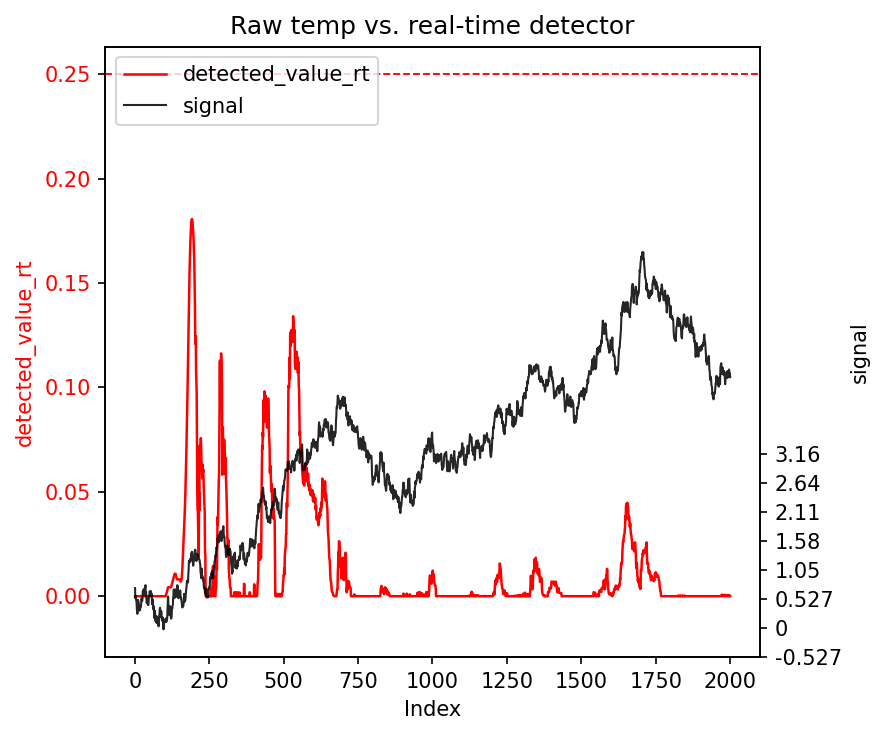

In [ ]:
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.25,
)


In [ ]:
rng = np.random.default_rng(3)
n = 2000
df = pd.DataFrame({
    "time": np.arange(1, n + 1),
    "temperature": np.cumsum(rng.normal(loc=0.0, scale=0.02, size=n)),
    "load": rng.normal(loc=-200.0, scale=5.0, size=n),
    "voltage": 4.0 + rng.normal(loc=0.0, scale=0.01, size=n),
    "force": rng.normal(loc=-900.0, scale=6.0, size=n),
})

In [ ]:
sig_res = build_signal_arimax_resid(
  data = df, time = "time",
  y_col = "temperature",
  xreg_cols = "voltage|force"
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
det_raw = detect_realtime(sig_res["time_ind"], sig_res["signal"], burn_in = 200)


(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

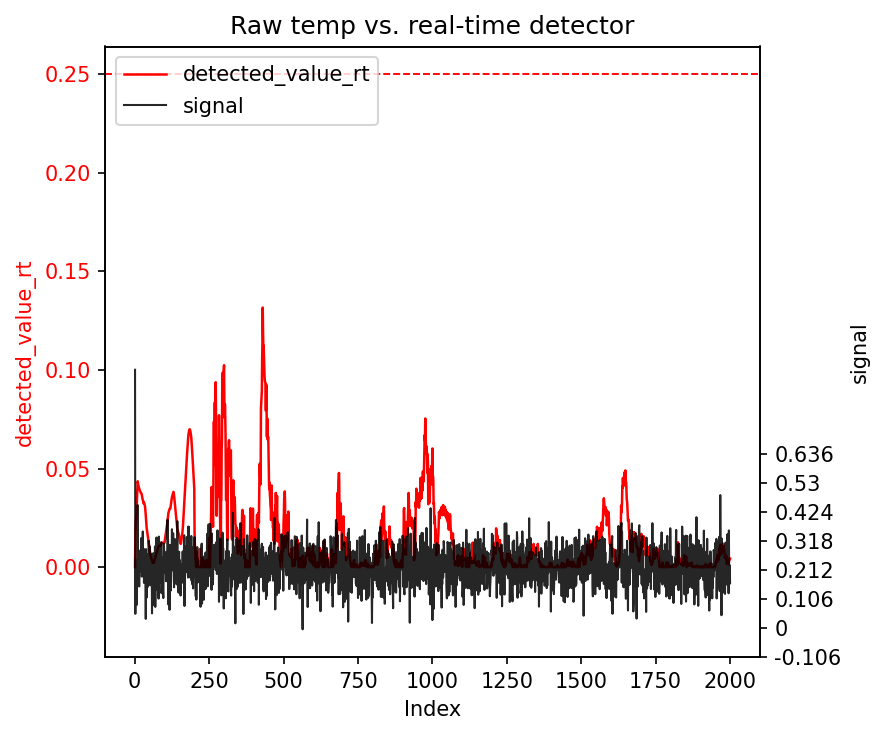

In [ ]:
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.25,
)


200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449


(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

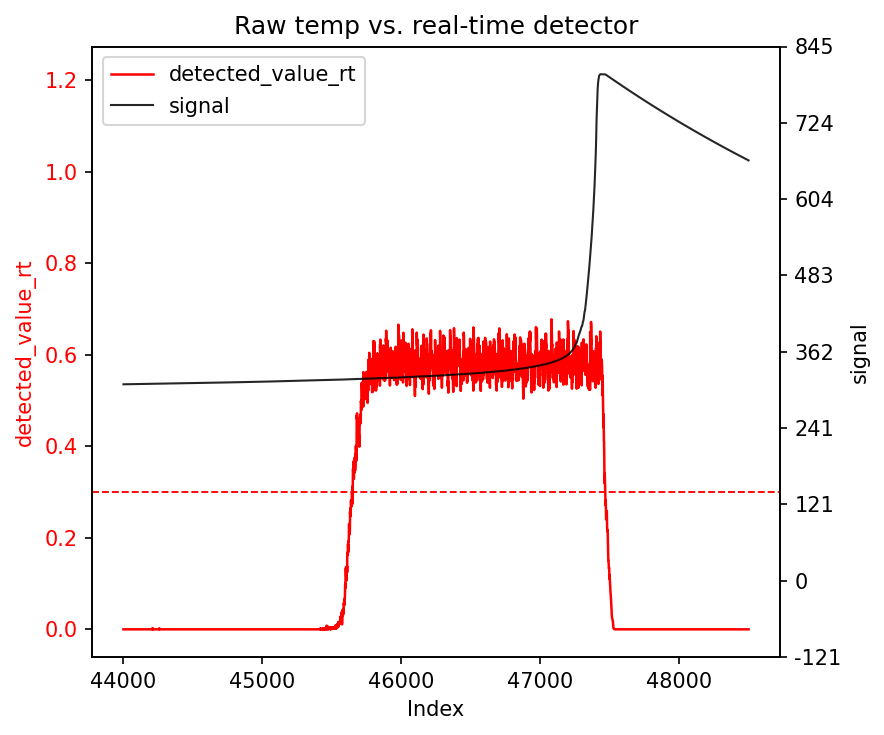

In [ ]:
df1 = pd.read_csv("mat4_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[44000:48500, :]
sig_raw = build_signal_raw(df1, time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], highwl = 100, burn_in = 200)
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.3
)


(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

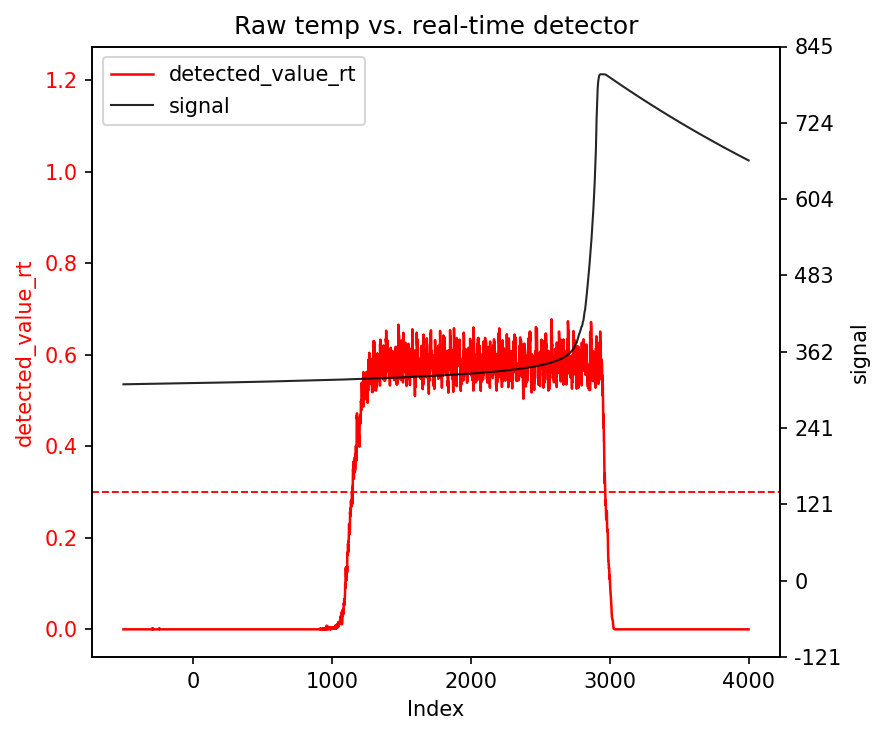

In [ ]:
det_raw["time_ind"] = det_raw["time_ind"] - 44500
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.3
)

In [ ]:
#Simulation Data:
df1 = pd.read_csv("mat3_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[23000:35000, :]

In [ ]:
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[23000:35000, :]

In [ ]:
import seaborn as sns
df1 = pd.read_csv("mat3_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[1:40000, :]
sig_raw = build_signal_raw(df1, time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], burn_in = 200)
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.3
)



KeyboardInterrupt



In [ ]:
sig_res = build_signal_arimax_resid(
  data = df1, time = "time",
  y_col = "Battery_Temperature",
  xreg_cols = "Battery_Voltage|Ocv|Reaction_Extent"
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

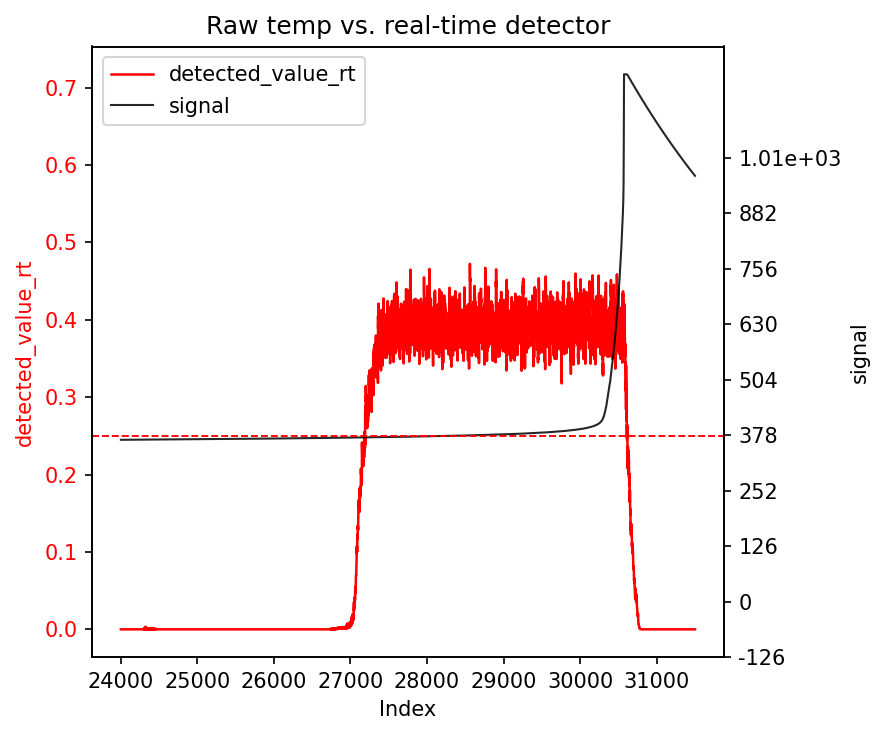

In [ ]:
df1 = pd.read_csv("mat3_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[24000:, :]
sig_raw = build_signal_raw(df1.iloc[:7500,], time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], highwl = 200, burn_in = 300)



In [ ]:
det_raw["time_ind"]= det_raw["time_ind"] - 24000

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

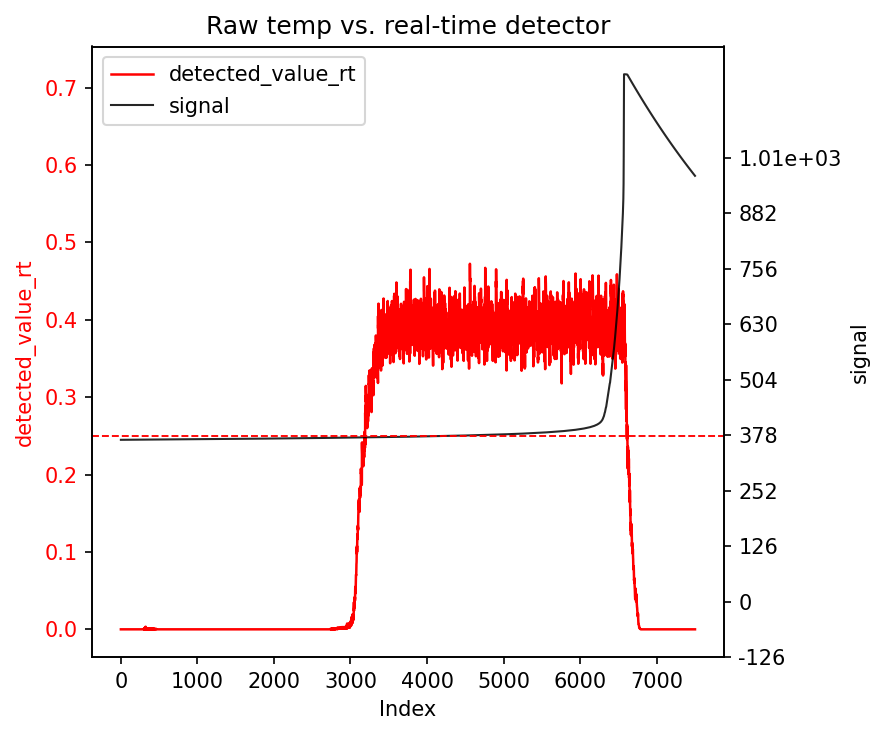

In [ ]:
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.25
)

In [ ]:
df1 = pd.read_csv("mat3_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[24000:, :]
sig_raw = build_signal_raw(df1.iloc[:7500,], time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], highwl = 200, burn_in = 300)
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.25
)

Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

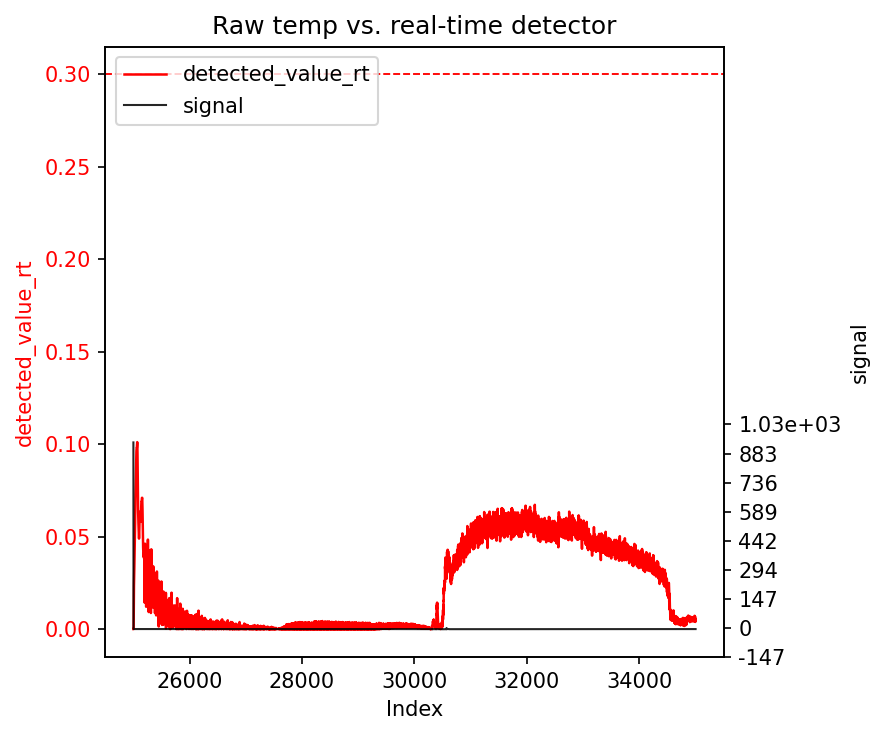

In [ ]:
#after building the residuals:
det_raw = detect_realtime(sig_res["time_ind"], sig_res["signal"], burn_in = 200)
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.3
)


In [ ]:
import seaborn as sns
df1 = pd.read_csv("mat2_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[1:40000, :]
sig_raw = build_signal_raw(df1, time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], burn_in = 200)
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.3
)
#Whether it can detect the significance point?

<Axes: xlabel='time', ylabel='Battery_Temperature'>

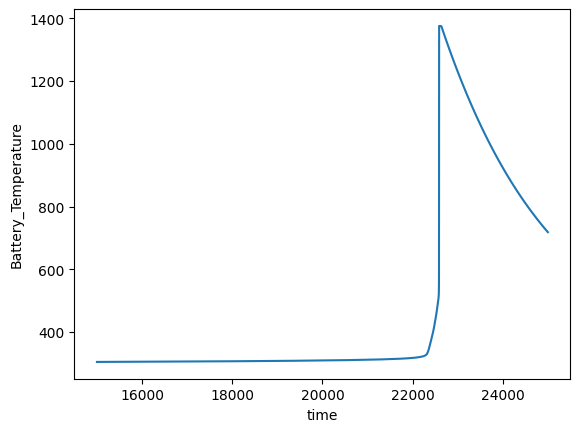

In [ ]:
df1 = pd.read_csv("mat5_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1= df1.iloc[15000:25000,]
sns.lineplot(data=df1, x="time", y="Battery_Temperature")

In [ ]:
df1 = pd.read_csv("mat5_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[18000:23500, :]
sig_raw = build_signal_raw(df1, time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], highwl = 100, burn_in = 200)


Streaming output truncated to the last 5000 lines.
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
7

KeyError: 'time_ind'

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

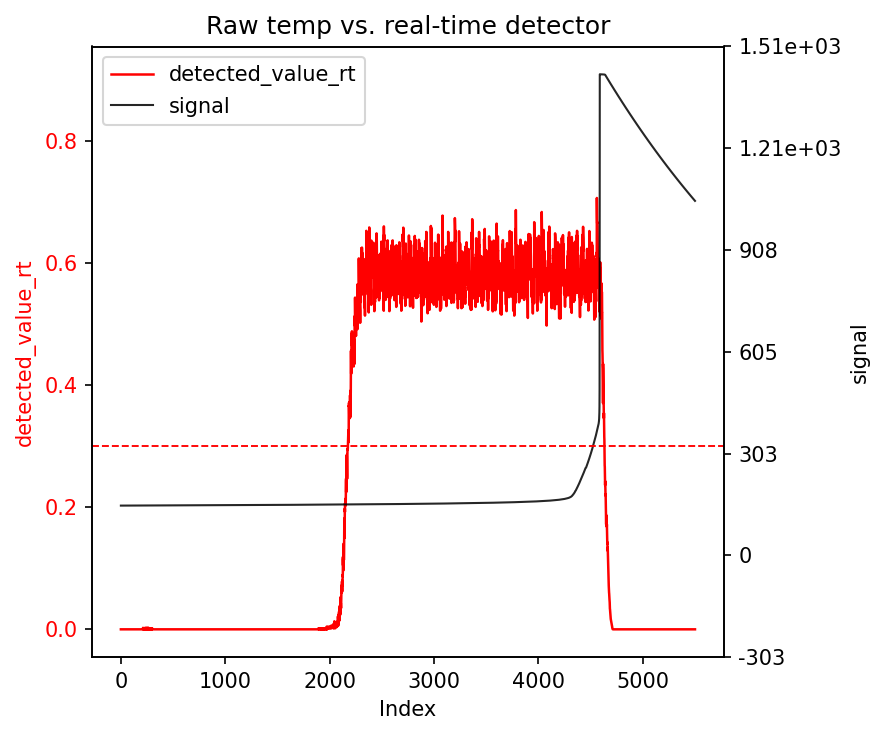

In [ ]:
det_raw["time_ind"] = det_raw["time_ind"] - 18000
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.3
)

<Axes: xlabel='time', ylabel='Battery_Temperature'>

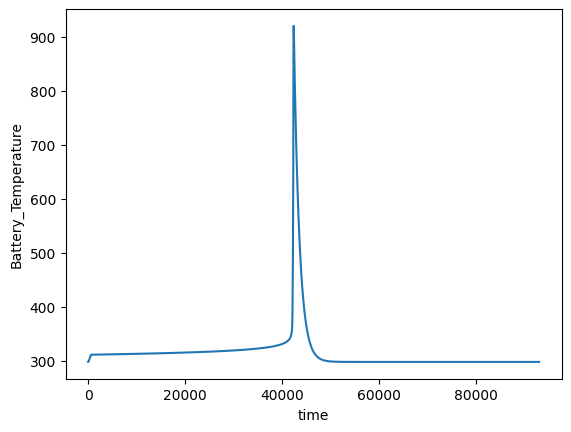

In [ ]:
df1 = pd.read_csv("mat1_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
sns.lineplot(data = df1, x = df1["time"], y = df1["Battery_Temperature"])

In [ ]:
df1 = pd.read_csv("mat1_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
df1 = df1.iloc[33000:43000, :]
sig_raw = build_signal_raw(df1, time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], highwl = 50, burn_in = 300)


Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

KeyError: 'time_in'

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

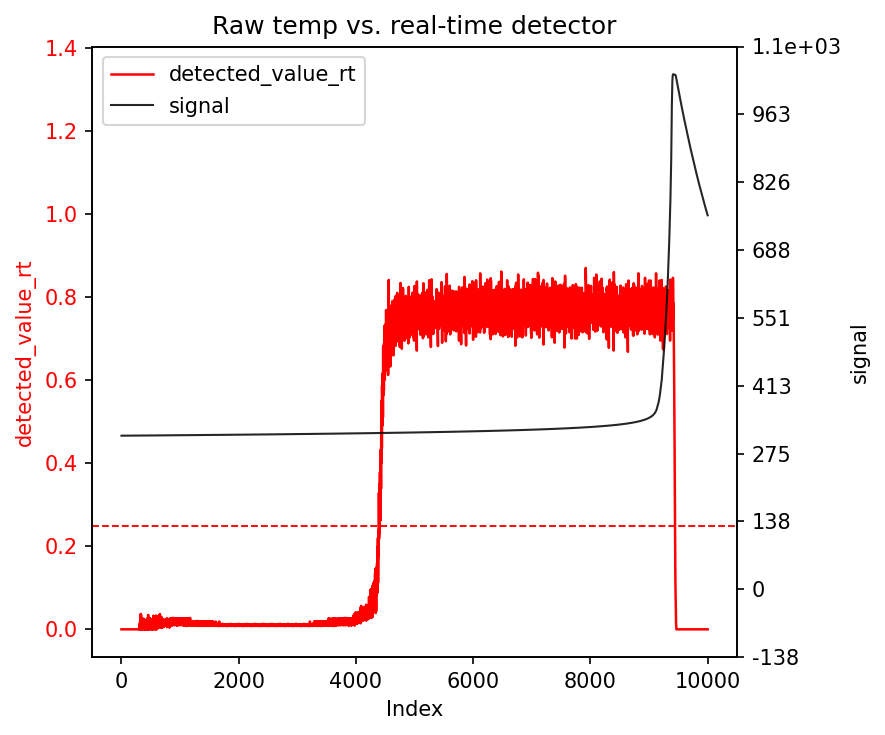

In [ ]:
det_raw["time_ind"] = det_raw["time_ind"] - 33000
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.25
)

<Axes: xlabel='time', ylabel='Battery_Temperature'>

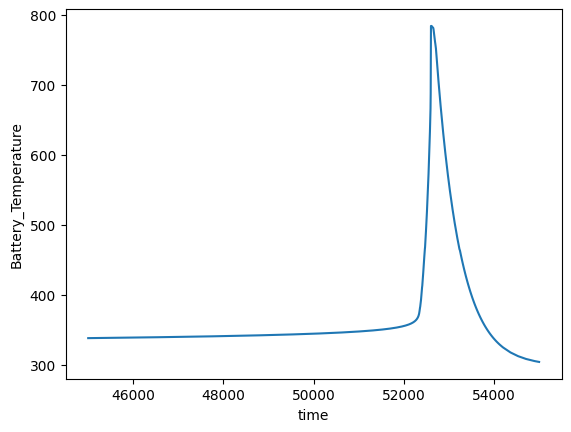

In [ ]:
df1 = pd.read_csv("mat10_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
sns.lineplot(data = df1.iloc[45000:55000], x = "time", y = "Battery_Temperature")

<Axes: xlabel='time', ylabel='Battery_Temperature'>

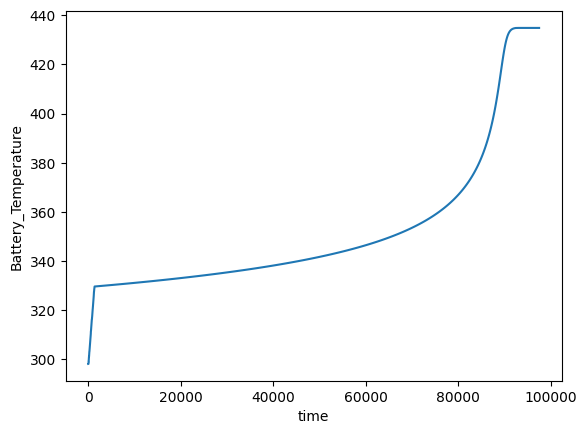

In [ ]:
df1 = pd.read_csv("mat11_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
sns.lineplot(data = df1, x = "time", y = "Battery_Temperature")

Streaming output truncated to the last 5000 lines.
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703
17704
17705
17706
17707
17708
17709
17710
17711
17712
17713
17714
17715
17716
17717
17718
17719
17720
17721
17722
17723
17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734
17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746
17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757
17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768
17769
17770
17771
17772
17773
17774
17775
17776
17777
17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
1

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

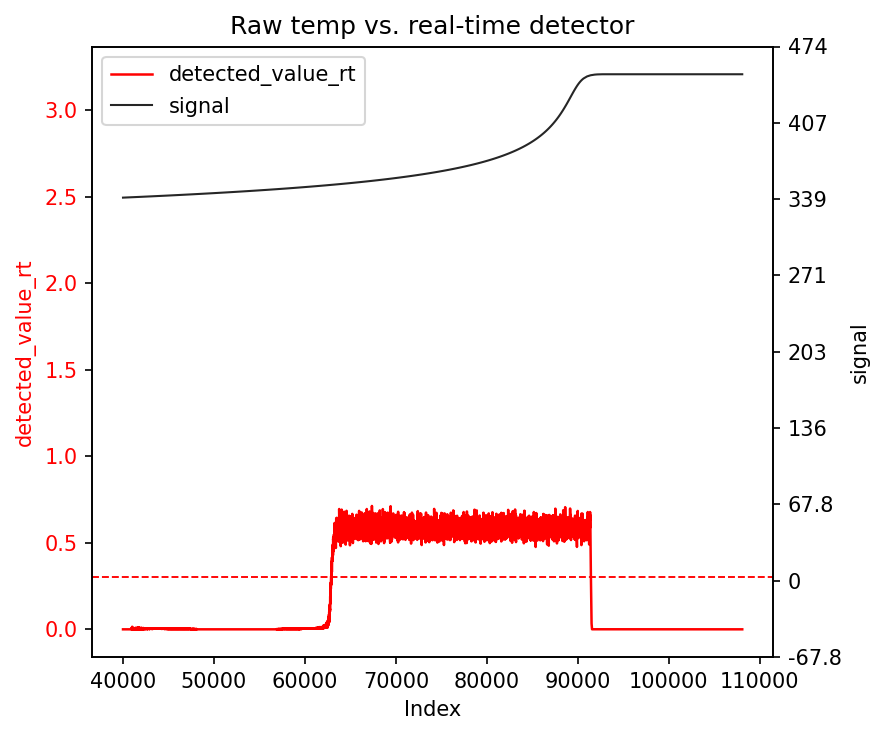

In [ ]:
df1 = pd.read_csv("mat11_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
#sns.lineplot(data = df1, x = "time", y = "Battery_Temperature")
df1 = df1.iloc[40000:, :]
df1 = df1.iloc[1::3]
sig_raw = build_signal_raw(df1, time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], highwl = 100, burn_in = 300)
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.3
)

In [ ]:
df1 = pd.read_csv("mat11_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
sns.lineplot(data = df1, x = "time", y = "Battery_Temperature")
df1 = df1.iloc[40000:, :]
sig_raw = build_signal_raw(df1, time = "time", col = "Battery_Temperature")
det_raw = detect_realtime(sig_raw["time_ind"], sig_raw["signal"], highwl = 100, burn_in = 300)
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.3
)

<Axes: xlabel='time', ylabel='Battery_Temperature'>

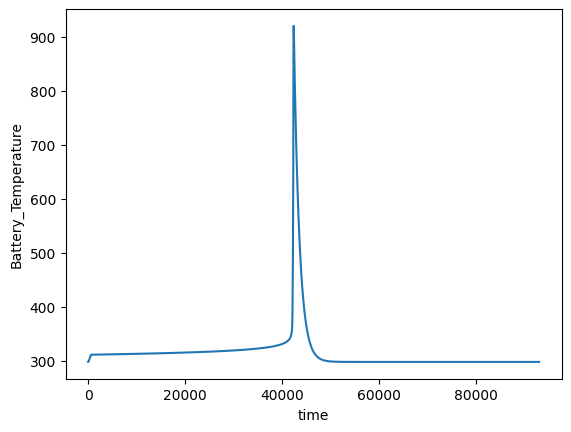

In [ ]:
#covariate adjustment:
import seaborn as sns
df1 = pd.read_csv("mat1_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
sns.lineplot(data = df1, x = "time", y = "Battery_Temperature")

In [ ]:
df1.head(5)

,State_Of_Charge,Battery_Temperature,Battery_Faults_Voltage_Drop,Reaction_Extent,Reaction_HeatRate,Charge,Battery_Current,Ocv,Heat_Dissipation_Rate,Battery_Voltage,time
0,1,298.15,0,0.000000e+00,0.002971,97200,0,4.19,-1.500000e-11,4.19,1
1,1,298.15,0,7.203049e-12,0.002971,97200,0,4.19,-1.500000e-11,4.19,2
2,1,298.15,0,6.983121e-11,0.002971,97200,0,4.19,-1.500000e-11,4.19,3
3,1,298.15,0,1.324594e-10,0.002971,97200,0,4.19,-1.500000e-11,4.19,4
4,1,298.15,0,1.950875e-10,0.002971,97200,0,4.19,-1.500001e-11,4.19,5


In [ ]:
sig_res = build_signal_arimax_resid(
  data = df1, time = "time",
  y_col = "Battery_Temperature",
  xreg_cols = "voltage|force|Battery_Voltage|Battery_Current|Reaction_Extent"
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:

det_raw = detect_realtime(sig_res.iloc[33000:43000,:]["time_ind"], sig_res.iloc[33000:43000,:]["signal"], burn_in = 200, highwl = 100)


Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

In [ ]:
sig_res.shape

(93114, 2)

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector For Multi-Dimensional Regression Adjustment'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

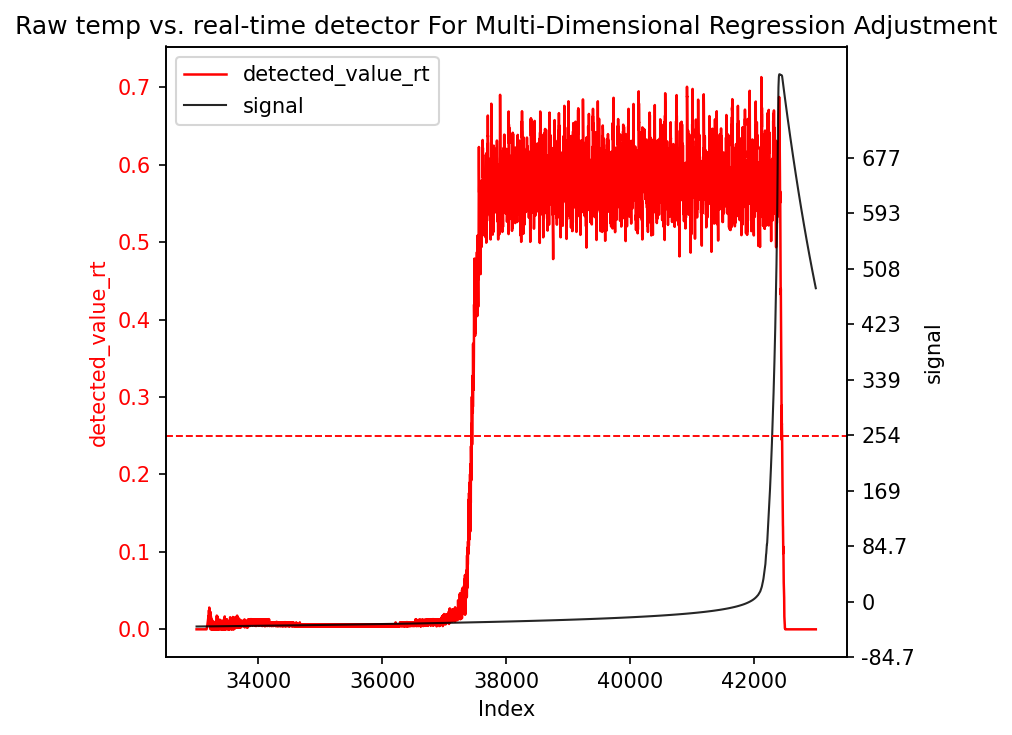

In [ ]:

plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector For Multi-Dimensional Regression Adjustment",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.25
)

<Axes: xlabel='time_ind', ylabel='signal'>

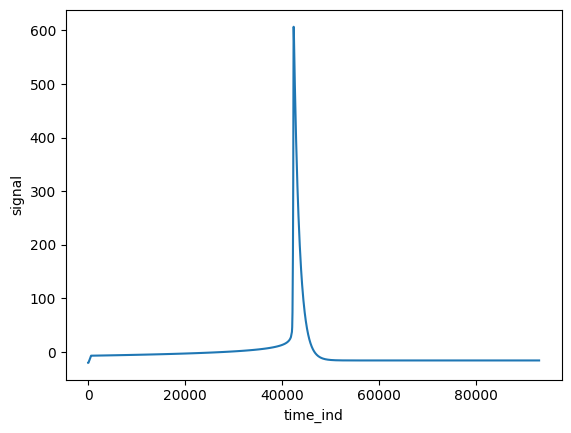

In [ ]:
sns.lineplot(data = sig_res, x = "time_ind", y = "signal")

In [ ]:
df1.head(5)

,State_Of_Charge,Battery_Temperature,Battery_Faults_Voltage_Drop,Reaction_Extent,Reaction_HeatRate,Charge,Battery_Current,Ocv,Heat_Dissipation_Rate,Battery_Voltage,time
0,1,298.15,0,0.000000e+00,0.002971,97200,0,4.19,-1.500000e-11,4.19,1
1,1,298.15,0,7.203049e-12,0.002971,97200,0,4.19,-1.500000e-11,4.19,2
2,1,298.15,0,6.983121e-11,0.002971,97200,0,4.19,-1.500000e-11,4.19,3
3,1,298.15,0,1.324594e-10,0.002971,97200,0,4.19,-1.500000e-11,4.19,4
4,1,298.15,0,1.950875e-10,0.002971,97200,0,4.19,-1.500001e-11,4.19,5


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='time_ind', ylabel='signal'>

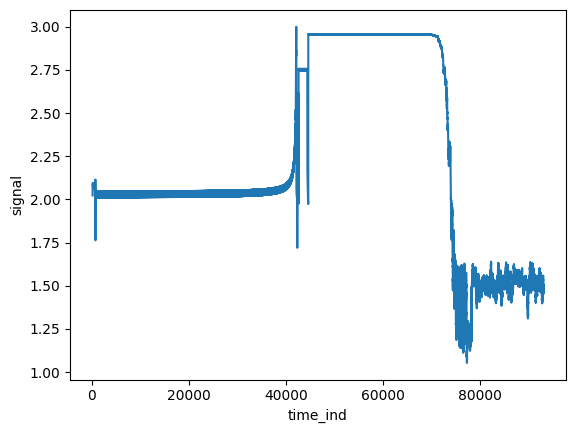

In [ ]:

sig_res = build_signal_arimax_svd(
  data = df1, time = "time",
  window = 200,
  y_cols = "Battery_Temperature|Battery_Voltage|voltage|force|Battery_Current|Reaction_Extent",
  xreg_cols = "Battery_Faults_Voltage_Drop|Reaction_HeatRate|Heat_Dissipation_Rate"
)
sns.lineplot(data = sig_res, x = "time_ind", y = "signal")

<Axes: xlabel='time_ind', ylabel='signal'>

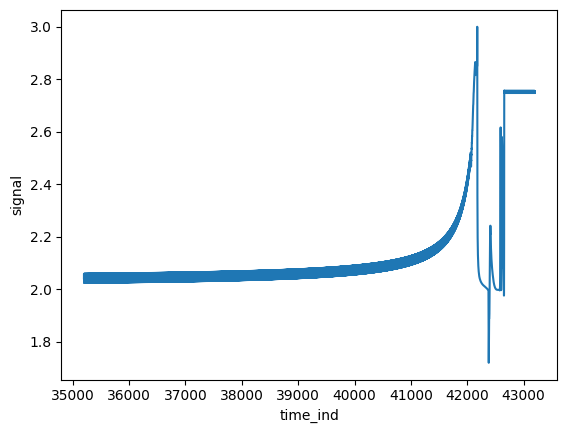

In [ ]:
sns.lineplot(data = sig_res.iloc[35000:43000], x = "time_ind", y = "signal")

Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector For Multi-Dimensional Regression Adjustment'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

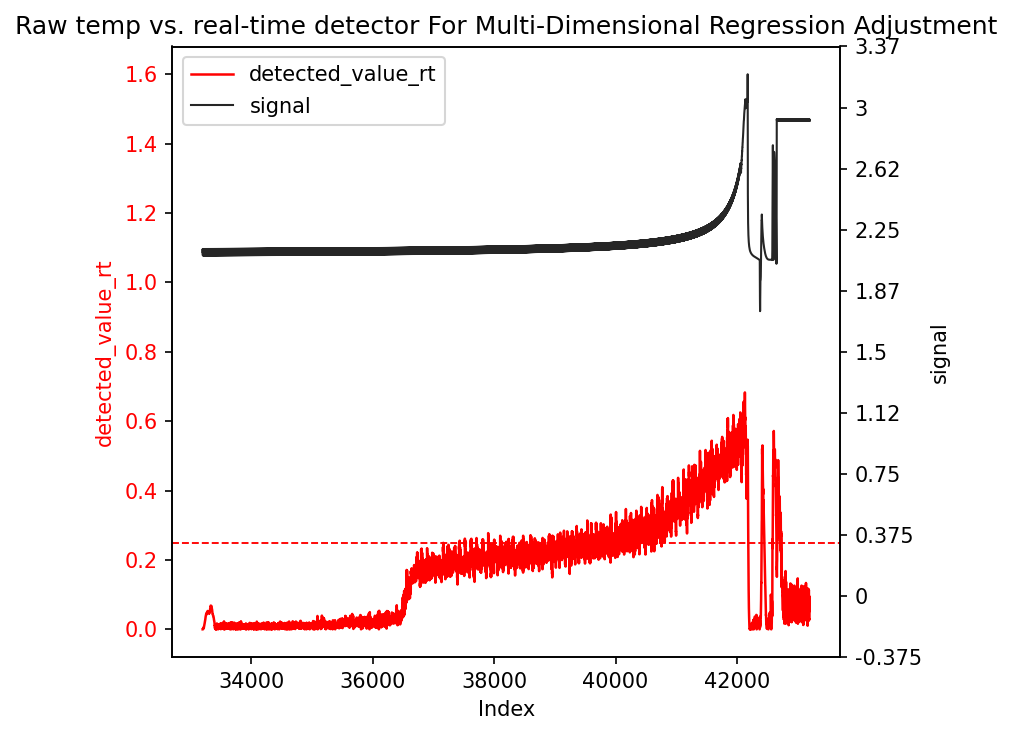

In [ ]:
det_raw = detect_realtime(sig_res.iloc[33000:43000,:]["time_ind"], sig_res.iloc[33000:43000,:]["signal"], burn_in = 200, highwl = 100)

plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector For Multi-Dimensional Regression Adjustment",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.25
)

(<Figure size 900x750 with 2 Axes>,
 <Axes: title={'center': 'Raw temp vs. real-time detector For SVD First Singular Value Adjustment'}, xlabel='Index', ylabel='detected_value_rt'>,
 <Axes: ylabel='signal'>)

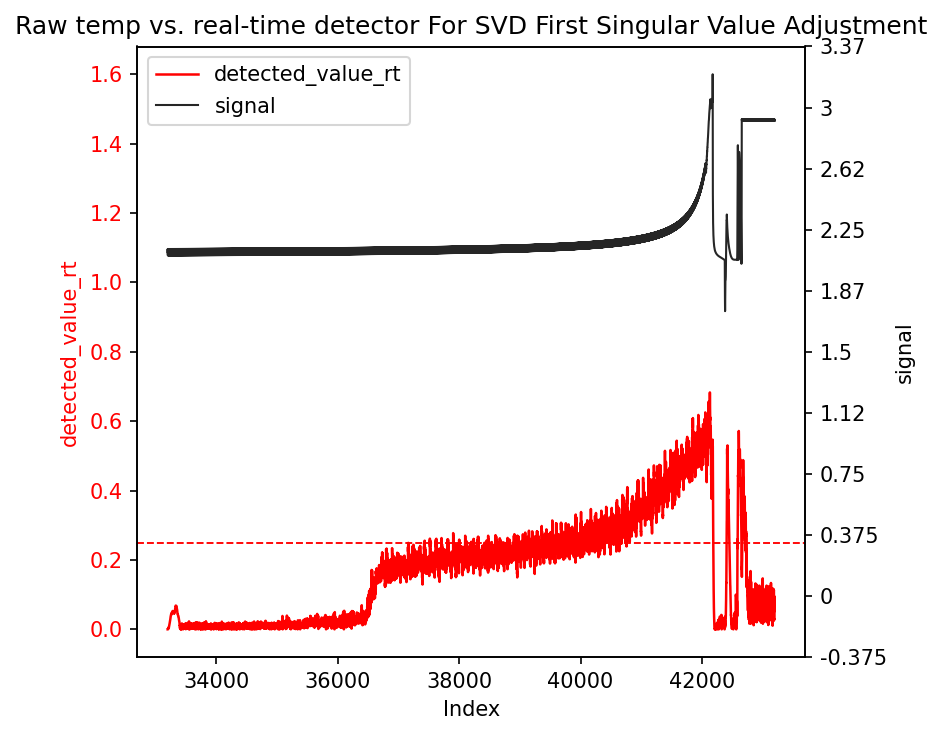

In [ ]:
plot_detection_overlay(
  det_raw,
  title        = "Raw temp vs. real-time detector For SVD First Singular Value Adjustment",
  score_label  = "detected_value_rt",
  signal_label = "signal",
  x_label      = "Index",
  threshold    = 0.25
)

In [ ]:
df1 = pd.read_csv("mat12_result.csv")
df1["time"] = np.arange(1, df1.shape[0] + 1)
sig_res = build_signal_arimax_svd(
  data = df1, time = "time",
  window = 200,
  y_cols = "Battery_Temperature|Battery_Voltage|voltage|force|Battery_Current|Reaction_Extent",
  xreg_cols = "Battery_Faults_Voltage_Drop|Reaction_HeatRate|Heat_Dissipation_Rate"
)
sns.lineplot(data = sig_res, x = "time_ind", y = "signal")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


NameError: name 'sns' is not defined